<a href="https://colab.research.google.com/github/soorajpu12/LSTproject/blob/master/LSTfromPath%26Row2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algorithm for Automated Mapping of Land Surface Temperature
Using LANDSAT 8 Satellite Data;
Ugur Avdan and Gordana Jovanovska

Rasterio code snippets taken from- https://geohackweek.github.io/raster/04-workingwithrasters/

In [1]:
pip install rasterio

     |████████████████████████████████| 18.2MB 1.3MB/s 


In [2]:
pip install pyproj

     |████████████████████████████████| 10.9MB 2.5MB/s 


In [3]:
# import the modules

import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [5]:
# change figure size

%pylab inline
pylab.rcParams['figure.figsize'] = (13, 13)

Populating the interactive namespace from numpy and matplotlib


Decimation factor= 9


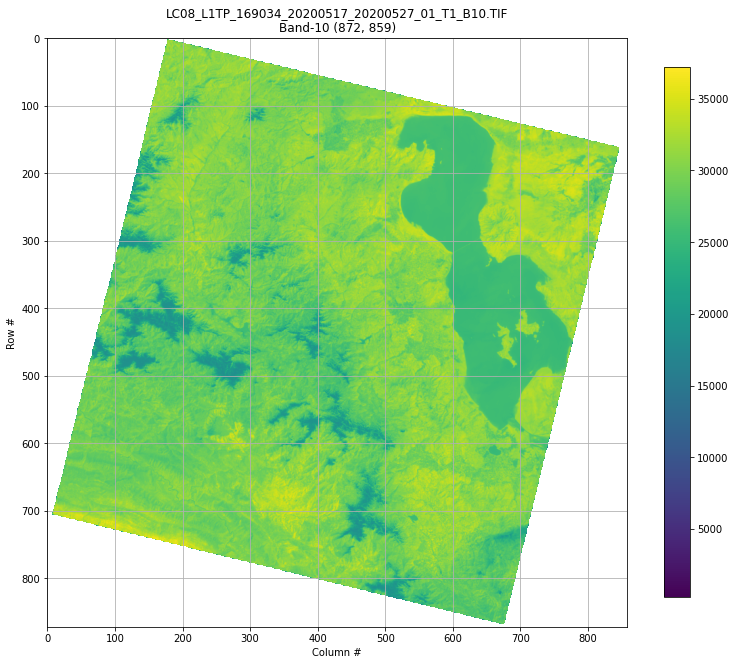

In [6]:
# Process and view the band 10 image taken from AWS

# enter path and row number

pathno = '169'
rowno = '034'

date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/'+pathno+'/'+rowno+'/LC08_L1TP_'+(pathno+rowno)+'_20200517_20200527_01_T1/' # change dates corresponding to the given path/row number
band_10 = 'LC08_L1TP_'+(pathno+rowno)+'_20200517_20200527_01_T1_B{}.TIF'.format(10)

with rasterio.open(url+band_10) as src1:
    profile = src1.profile
    oviews = src1.overviews(1) 
    oview = oviews[1]  
    print('Decimation factor= {}'.format(oview))
    decimated_band_10 = src1.read(1, out_shape=(1, int(src1.height // oview), int(src1.width // oview)))

    #############################################
    # remove border
    db10 = decimated_band_10.astype('f4')
    db10[db10==0] = np.nan
    #############################################

plt.imshow(db10)
plt.colorbar(shrink=0.75)
plt.title('{}\nBand-10 {}'.format(band_10, decimated_band_10.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()

2.1. Top of Atmospheric Spectral Radiance , 2.2. Conversion of Radiance to At-Sensor Temperature 

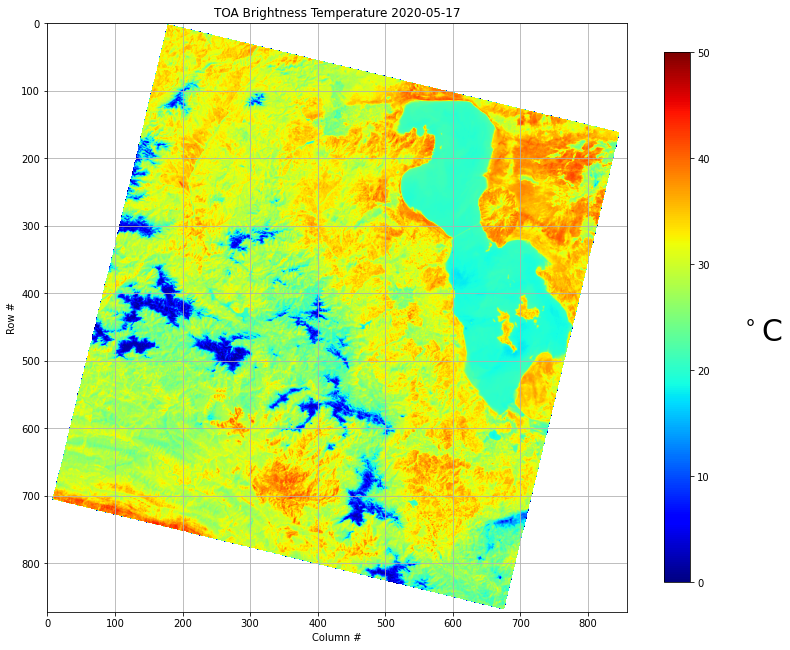

In [7]:
# define brightness temperature function

def DN_to_BrightnessTemp(image, M , A , k1, k2):     
    
    TOA_radiance = np.zeros(image.shape)
    brightness_temp = np.zeros(image.shape)        
    TOA_radiance = (M * image) + A # 2.1
    brightness_temp = (k2 / (np.log((k1 / TOA_radiance) + 1)))    # 2.2
    return brightness_temp

# input values manually from MTL.txt file

image = db10
M = 3.3420E-04
A = 0.10000
k1 = 774.8853 
k2 = 1321.0789    

# call the brightness temperature function

dn1 = DN_to_BrightnessTemp(image, M , A , k1, k2)

########################################
# remove border
dn1 = dn1.astype('f4')
dn1[dn1==0] = np.nan
########################################

plt.imshow(dn1-273.15, cmap='jet')
plt.title('TOA Brightness Temperature {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0,50)
ab= plt.colorbar(shrink=0.75)
ab.set_label('\t  $^\circ$C',fontsize=30, rotation=0)

2.3. NDVI Method for Emissivity Correction

2.3.1. Calculating NDVI

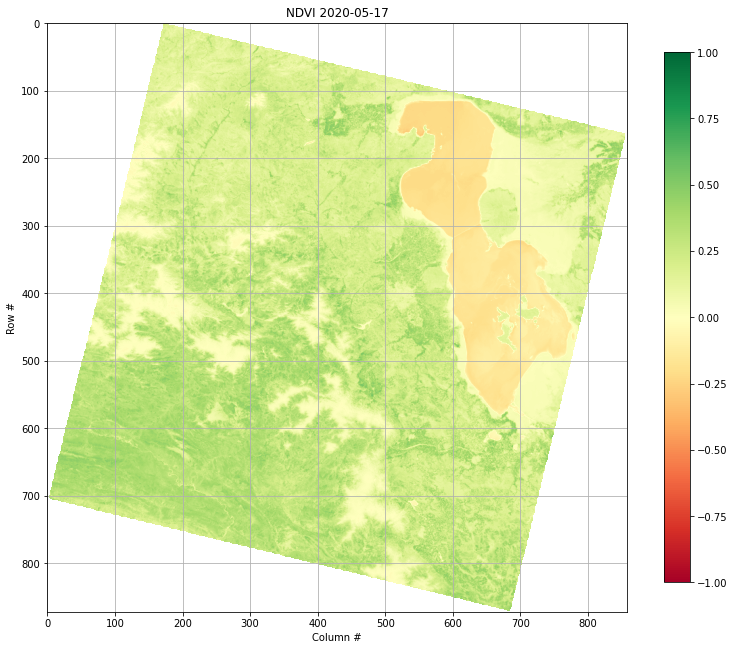

In [8]:
# use redband and nirband to find NDVI 

date = '2020-05-17'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/'+pathno+'/'+rowno+'/LC08_L1TP_'+(pathno+rowno)+'_20200517_20200527_01_T1/' # change dates corresponding to the given path/row number

redband = 'LC08_L1TP_'+(pathno+rowno)+'_20200517_20200527_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_'+(pathno+rowno)+'_20200517_20200527_01_T1_B{}.TIF'.format(5)

#######################################################################################

with rasterio.open(url+redband) as src:
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

#######################################################################################

with rasterio.open(url+nirband) as src:
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

#######################################################################################

# define the NDVI function

def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

# call the NDVI function    

ndvi = calc_ndvi(nir,red)

# plot the NDVI image

plt.imshow(ndvi, cmap='RdYlGn')
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(-1,1)
ab= plt.colorbar(shrink=0.75)

2.3.3. Calculating Land Surface Emissivity

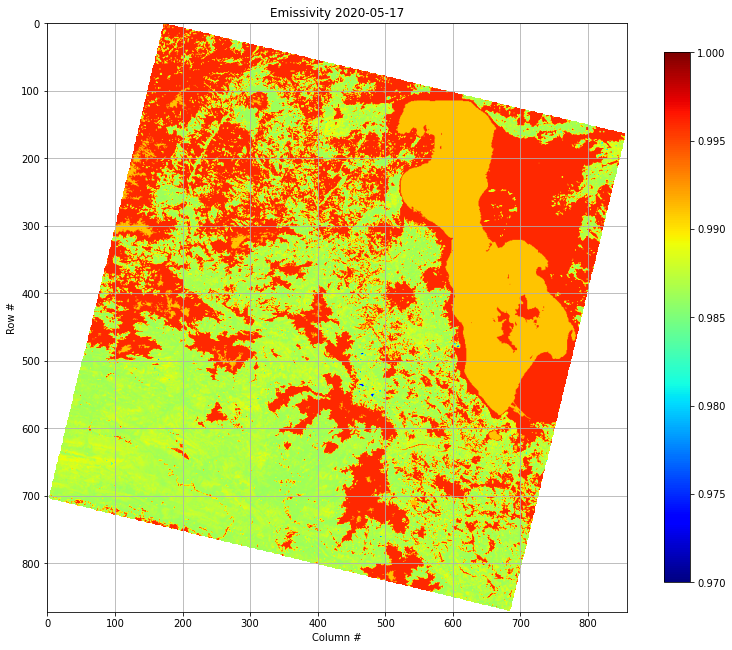

In [9]:
# define the emissivity function

def emmissivity_NDVI_threshold_TIR10(NDVI, mask):
        emissivity = np.zeros(NDVI.shape) 
        # Set values in emissivity matrix based on NDVI matrix value with same index
        type0 = NDVI <= 0
        type1 = (NDVI < 0.2) & (NDVI > 0)
        type2 = NDVI > 0.5
        type3 = (NDVI >= 0.2) & (NDVI <= 0.5)

        i0, j0 = np.where(type0)
        emissivity[i0, j0] = 0.991 # classified as water
        i1, j1 = np.where(type1)
        emissivity[i1, j1] = 0.996 # classified as soil
        i2, j2 = np.where(type2)
        emissivity[i2, j2] =  0.973 # covered with vegitation
        i3, j3 = np.where(type3)
        emissivity[i3, j3] = (0.004*(((NDVI[i3, j3] - 0.2)/(0.5 - 0.2))**2)) + 0.986 # mixture of soil and vegitation
        return emissivity

# call the emissivity function

emmiss = emmissivity_NDVI_threshold_TIR10(ndvi, None)     

# plot the emissivity image

##########################################
# remove border
emmiss = emmiss.astype('f4')
emmiss[emmiss==0] = np.nan
##########################################

plt.imshow(emmiss, cmap='jet')
plt.title('Emissivity {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0.97,1)
ab= plt.colorbar(shrink=0.75)

The last step of retrieving the LST or the emissivitycorrected land surface temperature 𝑇𝑠 is computed as follows

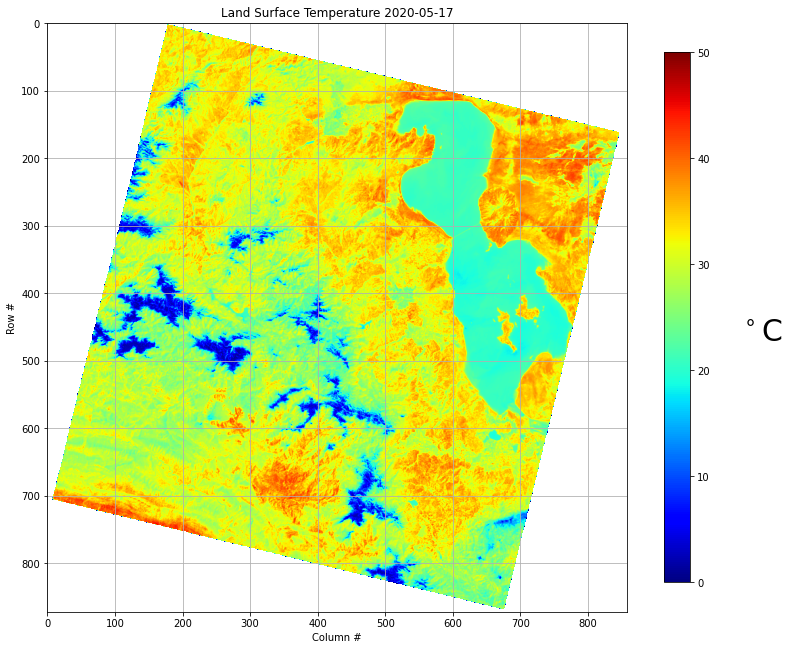

In [10]:
# define the LST function

# from reference 5 
lambda_emittedRadiance = 10.895E-6  # in m
rho = 1.438E-2 # in m-K

def compute_LST(TOA, emissivity):         
    land_surface_temp = TOA / (1 + (((lambda_emittedRadiance * TOA) / rho) * np.log(emissivity)))
    return land_surface_temp

# call the LST function    

lstm = compute_LST(dn1, emmiss)

# plot the LST image

#############################################
# remove border
lstm = lstm.astype('f4')
lstm[lstm==0] = np.nan
#############################################

plt.imshow(lstm-273.15, cmap='jet')
plt.title('Land Surface Temperature {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')
matplotlib.pyplot.grid()
plt.clim(0,50)
ab= plt.colorbar(shrink=0.75)
ab.set_label('\t  $^\circ$C',fontsize=30, rotation=0)

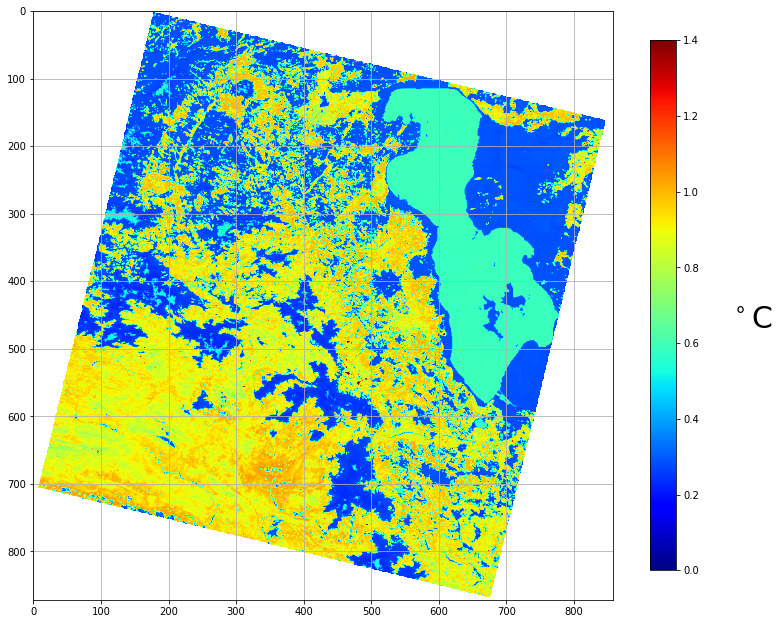

In [11]:
# difference between the LST and Brightness temp (LST - BT)

plt.imshow(lstm-dn1, cmap='jet')
plt.clim(0,1.4)
ab= plt.colorbar(shrink=0.75)
matplotlib.pyplot.grid()
ab.set_label('\t  $^\circ$C',fontsize=30, rotation=0)